**Корректность проверена на Python 3.7.4:**
+ pandas 0.25.1
+ numpy 1.16.5
+ matplotlib 3.1.1


# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
# (0 баллов)
# Считайте данные и выведите первые 5 строк
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


> *Я исправила следующий комментарий в соответствии с полученными графиками и ответами на форуме*

Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима (*правильно 1 - зима, 2 - весна, 3 - лето, 4 - осень*)
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6  (*правильно, 0 - воскресенье, 6 - суббота*)
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман) (*правильно от 1 до 3. Оценка 4 отсутствует*)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

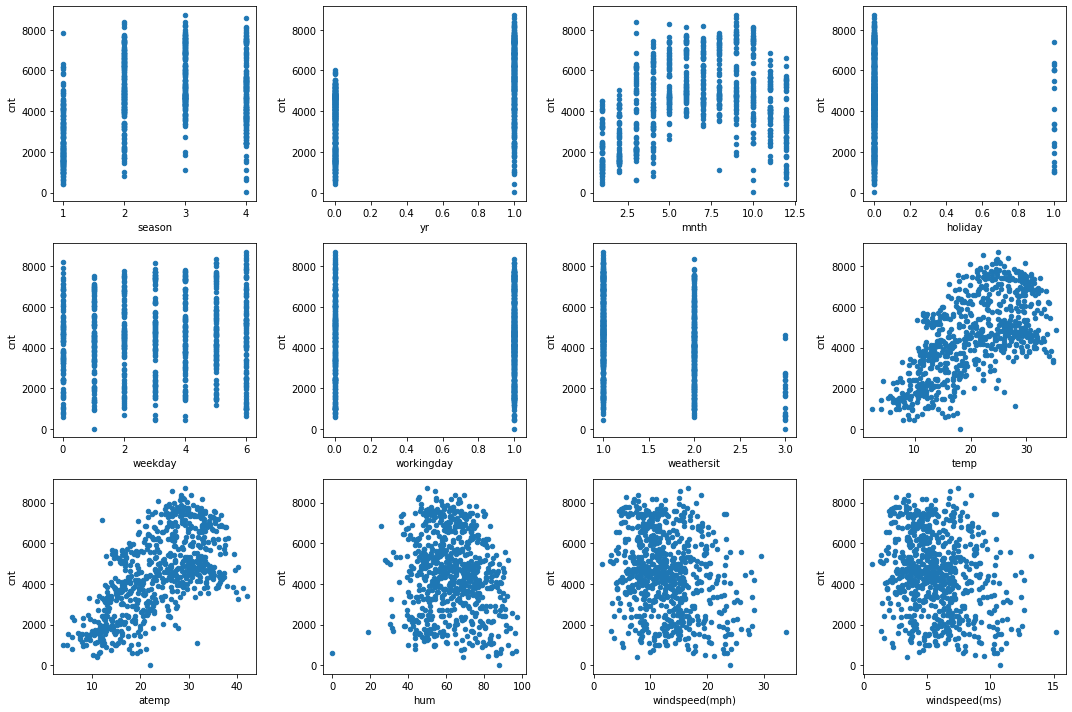

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])
fig.tight_layout()

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: 
    - Наибольшее число прокатов наблюдается в сентябре (9 месяц), наименьшее в январе.
    - Зависимость не линейная. В сентябре и октябре наблюдаются выбросы в меньшую сторону, в марте в большую.
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: 
    - Похоже, что от температуры число прокатов зависит линейно (причем и от фактической температуры и от температуры по ощущениям). 
    - В 2012 году видно прирост по сравнению с прошлым годом. Возможно есть обратная корреляция со скоростью ветра.

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [4]:
# Код 1.1 (0.5 балла)
# Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода corrwith:

pd.set_option('precision', 3)
df[df.columns[:-1]].corr()


# corrwith в следующей строке. Так нагляднее

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000,-0.002,0.831,-0.011,-3.080e-03,0.012,0.019,3.343e-01,0.343,0.205,-0.229,-0.229
yr,-0.002,1.000,-0.002,0.008,-5.461e-03,-0.002,-0.049,4.760e-02,0.046,-0.111,-0.012,-0.012
mnth,0.831,-0.002,1.000,0.019,9.509e-03,-0.006,0.044,2.202e-01,0.227,0.222,-0.208,-0.208
holiday,-0.011,0.008,0.019,1.000,-1.020e-01,-0.253,-0.035,-2.856e-02,-0.033,-0.016,0.006,0.006
weekday,-0.003,-0.005,0.010,-0.102,1.000e+00,0.036,0.031,-1.700e-04,-0.008,-0.052,0.014,0.014
workingday,0.012,-0.002,-0.006,-0.253,3.579e-02,1.000,0.061,5.266e-02,0.052,0.024,-0.019,-0.019
weathersit,0.019,-0.049,0.044,-0.035,3.109e-02,0.061,1.000,-1.206e-01,-0.122,0.591,0.040,0.040
temp,0.334,0.048,0.220,-0.029,-1.700e-04,0.053,-0.121,1.000e+00,0.992,0.127,-0.158,-0.158
atemp,0.343,0.046,0.227,-0.033,-7.537e-03,0.052,-0.122,9.917e-01,1.000,0.140,-0.184,-0.184
hum,0.205,-0.111,0.222,-0.016,-5.223e-02,0.024,0.591,1.270e-01,0.140,1.000,-0.248,-0.248


In [5]:
# corrwith
df[df.columns[:-1]].corrwith(df.cnt)

season            0.406
yr                0.567
mnth              0.280
holiday          -0.068
weekday           0.067
workingday        0.061
weathersit       -0.297
temp              0.627
atemp             0.631
hum              -0.101
windspeed(mph)   -0.235
windspeed(ms)    -0.235
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [6]:
# Код 1.2 (0.5 балла)
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000,0.992,0.127,-0.158,-0.158,0.627
atemp,0.992,1.000,0.140,-0.184,-0.184,0.631
hum,0.127,0.140,1.000,-0.248,-0.248,-0.101
windspeed(mph),-0.158,-0.184,-0.248,1.000,1.000,-0.235
windspeed(ms),-0.158,-0.184,-0.248,1.000,1.000,-0.235
cnt,0.627,0.631,-0.101,-0.235,-0.235,1.000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [7]:
# Код 1.3 (0.5 балла)
# Выведите средние признаков
df.mean()

season               2.497
yr                   0.501
mnth                 6.520
holiday              0.029
weekday              2.997
workingday           0.684
weathersit           1.395
temp                20.311
atemp               23.718
hum                 62.789
windspeed(mph)      12.763
windspeed(ms)        5.705
cnt               4504.349
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
# Код 2.1 (1 балл)
# Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели 
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, встроенной в язык python
# Названия признаков хранятся в переменной df.columns

linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
print(*zip(df.columns, np.round(linear_regressor.coef_, 4)), sep = '\n')

('season', 570.8637)
('yr', 1021.9664)
('mnth', -141.2983)
('holiday', -86.7624)
('weekday', 137.2245)
('workingday', 56.3894)
('weathersit', -330.23)
('temp', 367.4596)
('atemp', 585.5733)
('hum', -145.6091)
('windspeed(mph)', 12457617836216.549)
('windspeed(ms)', -12457617836415.006)


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [12]:
from sklearn.linear_model import Lasso, Ridge

In [13]:
# Код 2.2 (0.5 балла)
# Обучите линейную модель с L1-регуляризацией и выведите веса

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
print(*zip(df.columns, np.round(lasso_regressor.coef_, 4)), sep = '\n')

('season', 560.2416)
('yr', 1019.4635)
('mnth', -128.7306)
('holiday', -86.1528)
('weekday', 137.3479)
('workingday', 55.2124)
('weathersit', -332.3699)
('temp', 376.3632)
('atemp', 576.5308)
('hum', -144.1292)
('windspeed(mph)', -197.1397)
('windspeed(ms)', -0.0)


In [14]:
# Код 2.3 (0.5 балла)
# Обучите линейную модель с L2-регуляризацией и выведите веса

ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
print(*zip(df.columns, np.round(ridge_regressor.coef_, 4)), sep = '\n')

('season', 563.0646)
('yr', 1018.9484)
('mnth', -131.8733)
('holiday', -86.7461)
('weekday', 138.0051)
('workingday', 55.9031)
('weathersit', -332.3498)
('temp', 386.4579)
('atemp', 566.347)
('hum', -145.0713)
('windspeed(mph)', -99.2594)
('windspeed(ms)', -99.2594)


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [15]:
# Код 3.1 (1 балл)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso (вспомните встроенную в python функцию enumerate),
# а затем обучите Ridge и запишите веса в coefs_ridge.

for i, j in enumerate(alphas):
    lasso_regressor = Lasso(alpha = j)
    lasso_regressor.fit(X, y)
    coefs_lasso[i] = lasso_regressor.coef_
    
    ridge_regressor = Ridge(alpha = j)
    ridge_regressor.fit(X, y)
    coefs_ridge[i] = ridge_regressor.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5, 1.0, 'Ridge')

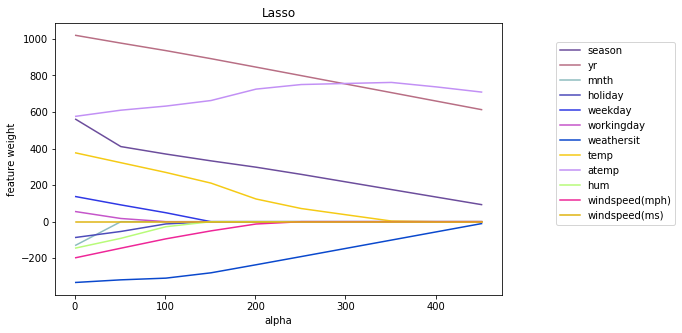

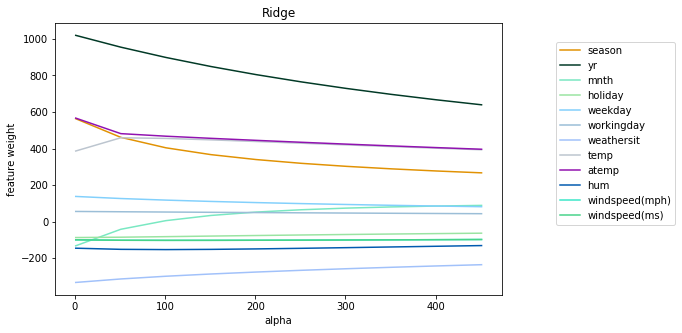

In [16]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ:\
    Чтобы однозначно ответить построим графики по каждому признаку отдельно (см. ниже).\
    Определенно Lasso агрессивнее снижает веса в сравнении с Ridge. За исключением признака *atemp* (температура по ощущениям). Вплоть до alpha приблизительно равного 350.  
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: \
    Они обнулятся. Из курса лекций нам известно, что задача регуляризации сводится к тому, чтобы максимально снизить норму вектора весов, помноженному на коэффициент $alpha$. Это значит, что при увеличении коэффицента alpha нужно снижать веса, а, следовательно, при очень больших $alpha$ единственным решением будет обнуление весов.\
    Другими словами, коэффициент $alpha$ отвечает за сложность модели. Чем он выше, тем проще модель. Естественно, самой простой моделью, является модель с нулевыми весами.
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ:  \
    (см. графики ниже).\
    Да, Lasso исключает один из признаков windspeed при любом значении alpha > 0. А Ridge не исключает оба и наделяет их примерно одинаковыми весами.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: \
    Однозначно Lasso. Lasso сразу исключил один из признаков windspeed.
    

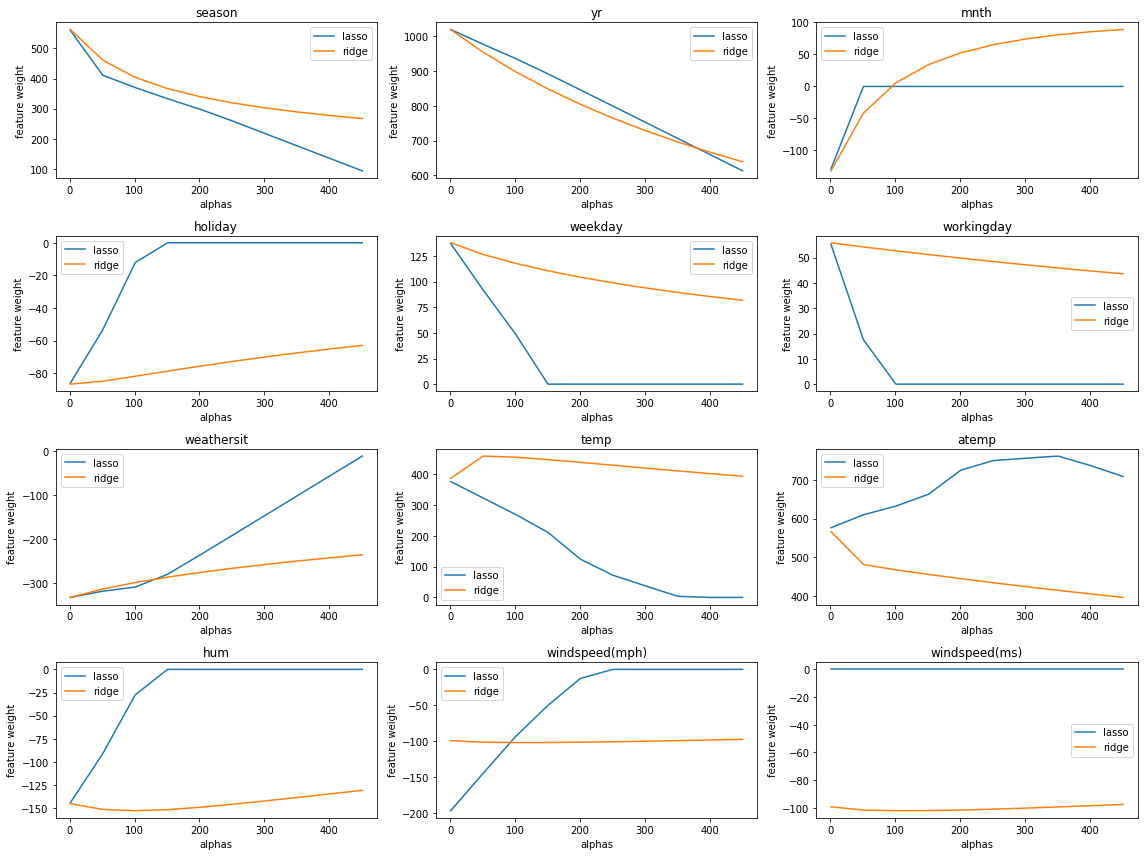

In [17]:
# К ответу на вопросы из Блока 2
fig, ax = plt.subplots(4,3, figsize=(16,12))
num = 0
for i in range(4):
    for j in range(3):
        ax[i][j].plot(alphas, coefs_lasso[:,num], label='lasso')
        ax[i][j].plot(alphas, coefs_ridge[:,num], label='ridge')
        ax[i][j].set_title(df.columns[num])
        ax[i][j].set_xlabel('alphas')
        ax[i][j].set_ylabel('feature weight')
        ax[i][j].legend(loc = 'best')
        num += 1
fig.tight_layout()

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [18]:
from sklearn.linear_model import LassoCV

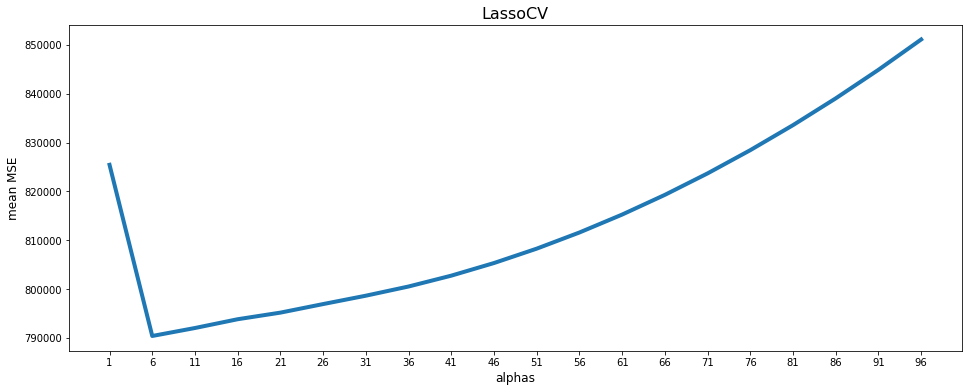

In [19]:
# Код 3.2 (1 балл)
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов
alphas = np.arange(1, 100, 5)
reg = LassoCV(cv = 3, alphas = alphas).fit(X,y)

plt.figure(figsize = (16,6))
plt.plot(reg.alphas_, [reg.mse_path_[i].mean() for i in range(reg.mse_path_.shape[0])], lw=4)
plt.xticks(alphas)
plt.xlabel('alphas', fontsize = 12)
plt.ylabel('mean MSE', fontsize = 12)
plt.title('LassoCV', fontsize = 16)

print()
# выбранное alpha и пары "признак-коэффициент" выведены ниже

In [20]:
print('Выбранное alpha = ', reg.alpha_)
print('Значения коээфициентов при данном alpha', *zip(df.columns, np.round(reg.coef_, 4)), sep = '\n')

Выбранное alpha =  6
Значения коээфициентов при данном alpha
('season', 532.019)
('yr', 1015.0602)
('mnth', -100.0395)
('holiday', -83.294)
('weekday', 132.5045)
('workingday', 51.5571)
('weathersit', -330.5599)
('temp', 370.6799)
('atemp', 581.3969)
('hum', -140.0074)
('windspeed(mph)', -191.7714)
('windspeed(ms)', -0.0)


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

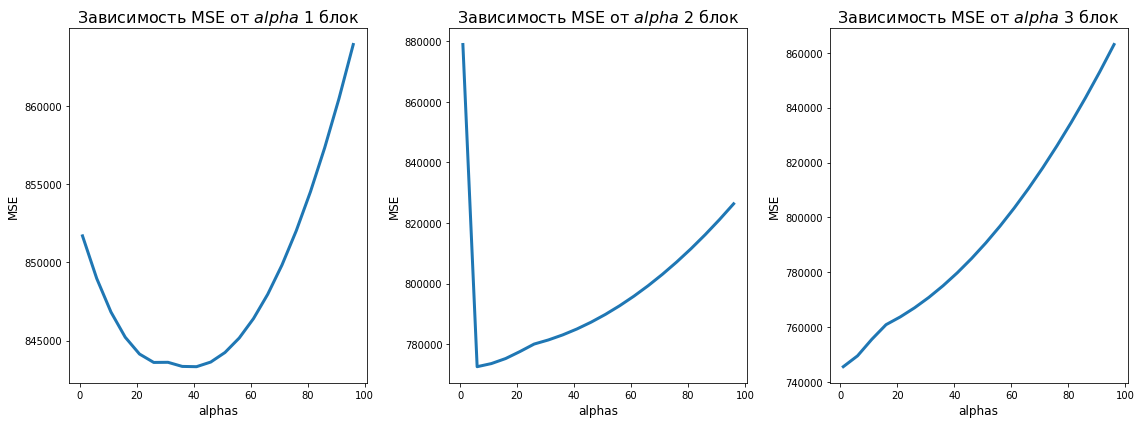

In [21]:
# Код 3.3 (1 балл)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
# На трех отдельных графиках визуализируйте столбцы .mse_path_
fig, ax = plt.subplots(1,3, figsize=(16,6))
for i in range(3):
    ax[i].plot(reg.alphas_, reg.mse_path_[:,i], lw=3)
    ax[i].set_title('Зависимость MSE от $alpha$ {} блок'.format(i+1), fontsize = 16)
    ax[i].set_ylabel('MSE',fontsize = 12)
    ax[i].set_xlabel('alphas',fontsize = 12)
fig.tight_layout()

# Значения alpha, соответствующие минимумам MSE вывела ниже

In [22]:
# Значения alpha, соответствующие минимумам MSE
for i in range(3):
    ind = np.argmin(reg.mse_path_[:,i])
    print(f'Минимальное значение MSE в {i+1} блоке соответствует значению alpha = {reg.alphas_[ind]}')
    

Минимальное значение MSE в 1 блоке соответствует значению alpha = 41
Минимальное значение MSE в 2 блоке соответствует значению alpha = 6
Минимальное значение MSE в 3 блоке соответствует значению alpha = 1


На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ:
     - Выводы сделаны на основе таблицы и графиков, представленных ниже.
     - 4 признака с наибольшими (положительными) коэфициентами: Год, Температура по ощущениям, Сезон, Температура.
     - Год. Коэффициент 1015.060. Да, есть возрастающая линейная зависимость. В 2012 году спрос на велосипеды был выше, чем в 2011. Однако, утверждать, что чем больше год, тем больше велосипедов захотят взять, нельзя. У нас всего 2 значения в выборке. Этого недостаточно, чтобы сделать вывод о том, что с каждым годом спрос на велосипеды растет сам по себе, независимо от других обстоятельств, в том числе данные по которым отсутствуют (например, маркетинговые стратегии или количество точек проката).
     - Температура по ощущениям. Коэффициент 581.397. На основе графика зависимости cnt от atemp нельзя утверждать, что зависимость линейная, скорее квадратичная или степенная. При увеличении температуры наблюдается восходящий тренд, но при достижении atemp приблизительно 30 градусов тренд сменяется на нисходящий - спрос на велосипеды падает из-за жары. Однако, можно утверждать, что до достижения порога в 30 градусов, при увеличении значения признака спрос на велосипеды растет.
     - Сезон. Коэффициент 532.019. На основе графика зависимости cnt от season нельзя утверждать, что зависимость линейная и при увеличении признака увеличивается спрос. По графику заметно, что летом (3 сезон) самый высокий спрос, ниже весной (2 сезон) и самый низкий зимой (1 сезон). Однако, осенью (4 сезон) спрос ниже, чем летом, и примерно находится на уровне весны. Ниже представлены для сравнения 2 графика - зависимость спроса от сезона и зависимость температуры от сезона, расчитаны средние и медианные показатели температуры и спроса для каждого сезона. Можно предположить, что температура и сезонность независимо влияют на показатели спроса, но для этого требуется провести дополнительное исследование (за рамками данного проекта).
     - Температура. Коэффициент 370.680. Не смотря на то, что коэффициент ниже, чем у температуры по ощущениям, зависимость спроса практически идентичная. Направление тренда меняется в окрестностях 25 градусов (что соответствует приблизительно 30 градусам температуры по ощущениям - см. графики ниже). Можно говорить о том, что зависимость спроса от температуры линейная до порога в 25 градусов. И можно утверждать, что при повышении температуры до 25 градусов, спрос на велосипеды растет с ростом температуры.

Я считаю, что из указанных 4 признаков необходимо исключить atemp, поскольку она имеет очевидную линейную зависимость от temp, но из этих двух признаков temp является более объективным.      

2. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ:
     - Выводы сделаны на основе таблицы и графиков, представленных ниже.
     - Оценка благоприятности погоды. Видна убывающая зависимость, но не линейная. При увеличении оценки (ухудшении погодных условий) с 1 на 2 спрос на велосипеды снижается, но не сильно. Однако спрос резко снижается при оценке 3. В случае линейной модели спрос снижался бы равномерно.
     - Скорость ветра в милях в час. Видна убывающая зависимость, но не линейная. Спрос практически отсутсвует при windspeed(mph) меньше 5 и больше 25. И максимум спроса приходится на интервал windspeed(mph) от 10 до 15. Нельзя утверждать, что чем больше величина признака, тем меньше людей хотят взять велосипеды.
     - Влажность. Видна убывающая зависимость, но не линейная. Спрос практически отсутсвует при hum ниже 40 и выше 90. И максимум спроса приходится на интервал hum от 50 до 70. Нельзя утверждать, что чем больше величина признака, тем меньше людей хотят взять велосипеды.

3. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ:
     - Единственным таким признаком является windspeed(ms): скорость ветра в метрах в секунду. Разумно, что модель с L1-регуляризацией исключила один из 2-х одинаковых признаков, равных скорости ветра. На графике ниже видна абсолютно линейная зависимость признаков windspeed(ms) и windspeed(mph). Не верно утверждать, что данный признак не влияет на спрос на велосипеды. Он всего лишь дублирует другой признак, выраженный в другой размерности. Модель исключила один из коллинеарных признаков.

#### *К ответу № 1. Выбор признаков. Графики зависимости cnt от признака.*

Выведем еще раз пары признак-коэффициент в виде таблице. И сразу отсортируем по значениям.

In [23]:
df_coef = pd.DataFrame(np.round(reg.coef_, 4), index = df.columns[:-1])
df_coef.columns = ['Коэффициенты']
df_coef.sort_values(by='Коэффициенты', ascending=False, inplace = True)
df_coef

,Коэффициенты
yr,1015.060
atemp,581.397
season,532.019
temp,370.680
weekday,132.505
workingday,51.557
windspeed(ms),-0.000
holiday,-83.294
mnth,-100.040
hum,-140.007


4 признака с наибольшими (положительными) коэфициентами:
    - Год. Коэффициент 1015.060
    - Температура по ощущениям. Коэффициент 581.397
    - Сезон. Коэффициент 532.019.
    - Температура. Коэффициент 370.680.
Еще раз построим графики зависимостей cnt от этих признаков для наглядности (и увеличим масштаб).

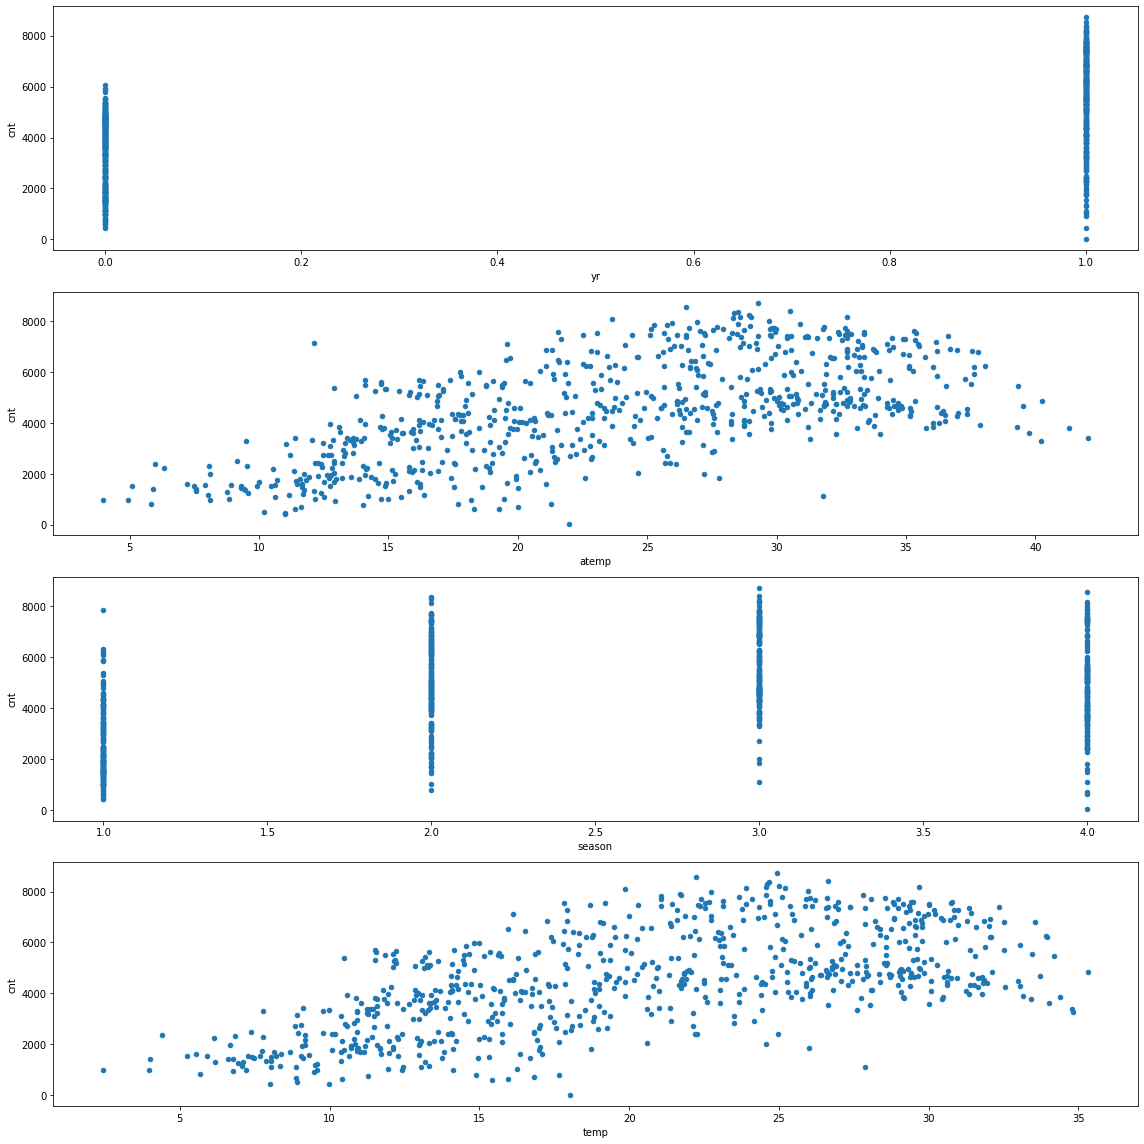

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 16))
for idx, feature in enumerate(df[['yr', 'atemp', 'season', 'temp']]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx])
fig.tight_layout()

Посмотрим, на различные значения температуры в каждом сезоне

In [59]:
df_temp = df.groupby(['season']).aggregate({'temp': [min, max, 'mean', 'median']}).rename(columns={'temp':'Температура'})
df_temp

Температура                        
               min     max    mean  median
season                                    
1            2.424  23.473  12.208  11.719
2           10.375  33.142  22.321  23.045
3           19.236  35.328  28.959  29.298
4            9.054  26.957  17.339  16.776

Посмотрим, на различные значения спроса на велосипеды в каждом сезоне

In [42]:
df_cnt = df.groupby(['season']).aggregate({'cnt': [min, max, 'mean', 'median']}).rename(columns={'cnt':'Количество арендованных велосипедов'})
df_cnt

Количество арендованных велосипедов                        
                                       min   max      mean  median
season                                                            
1                                      431  7836  2604.133  2209.0
2                                      795  8362  4992.332  4941.5
3                                     1115  8714  5644.303  5353.5
4                                       22  8555  4728.163  4634.5

Чтобы нагляднее увидеть зависимость спроса на велосипеды от сезона построим 2 графика:
 - зависимость cnt от сезона
 - зависимость температуры от сезона

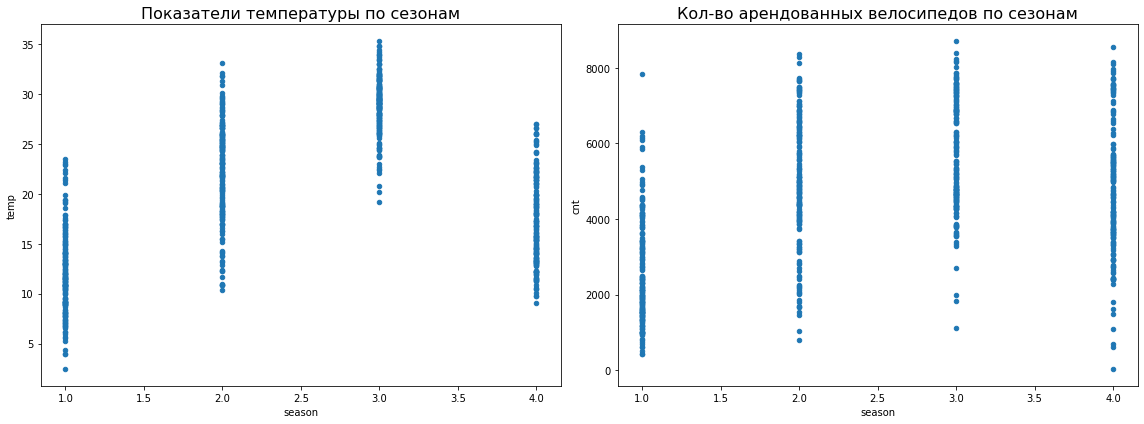

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
df.plot('season', 'temp', subplots=True, kind="scatter", ax=ax[0])
df.plot('season', 'cnt', subplots=True, kind="scatter", ax=ax[1])
ax[0].set_title('Показатели температуры по сезонам', fontsize = 16)
ax[1].set_title('Кол-во арендованных велосипедов по сезонам', fontsize = 16)
fig.tight_layout()
print()

Посмотрим зависимость температуры по ощущениям от температуры воздуха

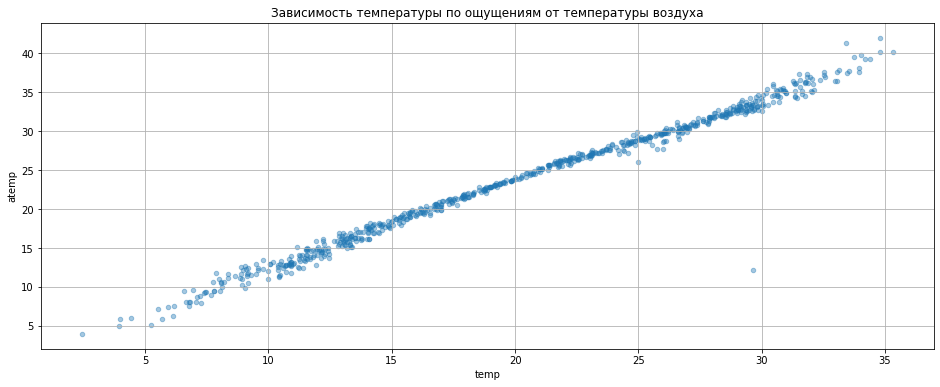

In [30]:
df.plot('temp', 'atemp', kind="scatter", figsize = (16, 6), grid=True, alpha=0.4,
        title = 'Зависимость температуры по ощущениям от температуры воздуха')
print()

#### *К ответу № 2. Выбор признаков. Графики зависимости cnt от признака.*

3 признака с наибольшими по модулю отрицательными коэфициентами:
    - Оценка благоприятности погоды. Коэффициент -330.560
    - Скорость ветра в милях в час. Коэффициент -191.771
    - Влажность. Коэффициент -140.007.
Еще раз построим графики зависимостей cnt от этих признаков для наглядности (и увеличим масштаб).

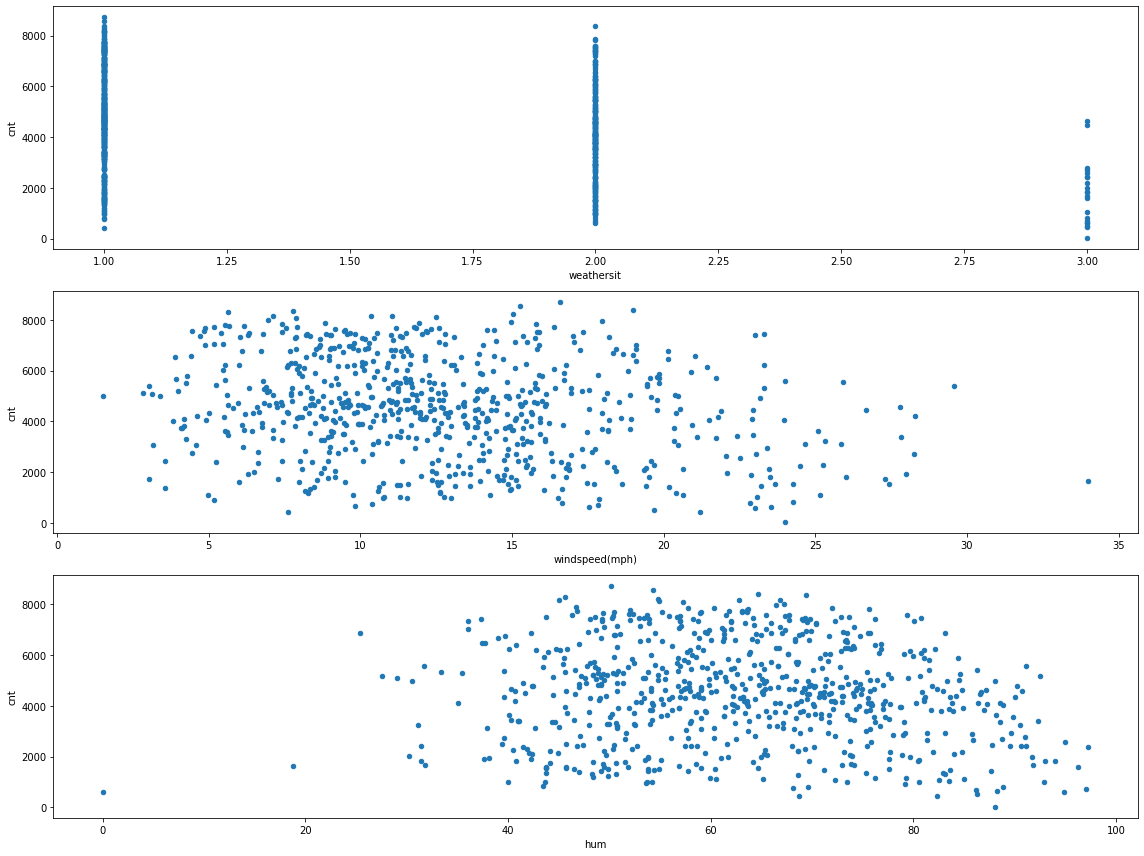

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))
for idx, feature in enumerate(df[['weathersit', 'windspeed(mph)', 'hum']]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx])
fig.tight_layout()

#### *К ответу № 3. Выбор признаков. Графики зависимости cnt от признака.*

Единственным признаком, чей вес близок к нулю, является скорость ветра в метрах в секунду. Построим график зависимости скоростей ветры, выраженных в разных единицах.

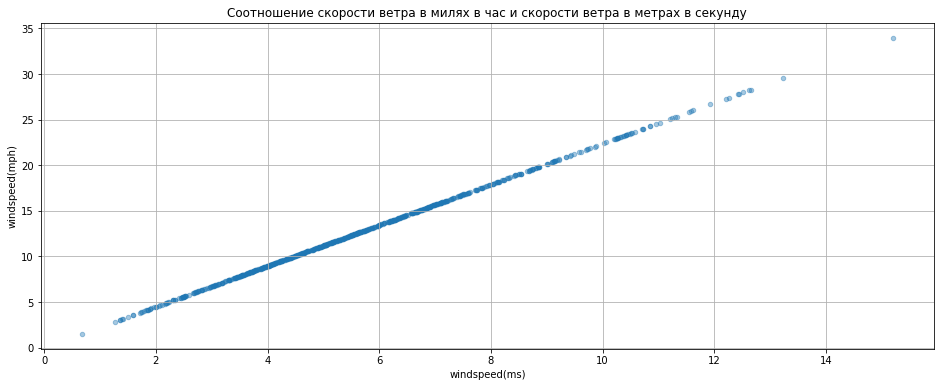

In [62]:
df.plot('windspeed(ms)', 'windspeed(mph)', kind="scatter", figsize = (16, 6), grid=True, alpha=0.4,
        title = 'Соотношение скорости ветра в милях в час и скорости ветра в метрах в секунду')
print()

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.